# Carga de librarías

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import urllib.request
from urllib.parse import urlparse

from wordcloud import WordCloud
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.stem.snowball import SpanishStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Extracción de datos

**Definición de una función para extraer el contenido de la página donde se encuentran los datos**

In [ ]:
#https://practicaldatascience.co.uk/data-science/how-to-parse-xml-sitemaps-using-python
def get_sitemap(url):
    """Scrapes an XML sitemap from the provided URL and returns XML source.

    Args:
        url (string): Fully qualified URL pointing to XML sitemap.

    Returns:
        xml (string): XML source of scraped sitemap.
    """

    response = urllib.request.urlopen(url)
    xml = BeautifulSoup(response,

                        'lxml-xml',
                         from_encoding=response.info().get_param('charset'))

    return xml

**Se aplica la función y en el objeto xml se identifican las etiquetas que contienen la información de interés, en este caso los comentarios se encuentran en _content_ y la etiqueta de sentimientos en _sentiments_**

In [ ]:
#### Para leer el archivo (general-train-tagged-3l.xml) de forma local
'''with open('general-train-tagged-3l.xml', 'r') as f:
  data = f.read()

xml = BeautifulSoup(data, 'xml')

content = xml.find_all('content')
value = xml.find_all('sentiments')'''

In [ ]:
#### Para leer el archivo (general-train-tagged-3l.xml) desde una UR, la cual se debe solicitar al TASS a través del correo que muestran en su página http://tass.sepln.org/
url = ""
xml = get_sitemap(url)

content = xml.find_all('content')
value = xml.find_all('sentiments')

# Preprocesamiento


In [ ]:
sw = stopwords.words('spanish') + ['q','p','d','x','rt','pp']

## Funciones

In [ ]:
def contraer(txt):
  t = txt[:2]
  i = 2
  while len(txt) > i:
    if t[-1] == txt[i] and t[-2] == txt[i]:
      k = ''
    else:
      k = txt[i]
    t += k
    i +=1
  return t

In [ ]:
def normaliza(txt):
  t = txt.replace('–','').replace('`','').replace('´','').replace('¿','').replace('?','').replace('¡','').replace('!','').replace('«','').replace('»','').replace('.','').replace(',','').replace(';','').replace(':','').replace('…','').replace('’','').replace('(','').replace(')','').replace('{','').replace('}','').replace('[','').replace(']','').replace('"','').replace('-','').replace('\n','').replace('$','').replace('/','').replace('_','').replace('“','').replace('rt ','').replace('—','').replace('|','').replace('❤','').replace('♥','').replace('”','').replace('<','').replace('>','').replace('&','').replace('%','').replace('*','').replace('¬','').replace('★','').replace('☆','').replace('+','')
  t = re.sub(r'@\w+',r'',t)
  t = re.sub(r'http...\w+',r'',t)
  t = re.sub(r'[0-9]',r'',t)
  t = re.sub(r'#\w+',r'',t)
  t = re.sub(r'[^\w\s]', '',t)
  t = t.lower()
  t = t.split()
  t = [contraer(x) for x in t]
  t = [w for w in t if not w in sw]
  t = ' '.join(t)
  return t

**A los comentarios y sentimientos se convierten a lista y cada elemento a texto para poder limiar las cadenas**

In [ ]:
content = list(content)
content = [str(x) for x in content]
content = [x[re.search('<content>',x).end():re.search('</content>',x).start()] for x in content]

tags = list(value)
tags = [str(t) for t in tags]
tags = [t[re.search('<sentiments>\n<polarity><value>',t).end():re.search('</value>',t).start()] for t in tags]
set(tags)

{'N', 'NEU', 'NONE', 'P'}

**Se eliminan los registros cuyo sentimiento está etiquedado como NONE**

In [ ]:
print(f'Contenido: {len(content)} -- Tags: {len(tags)}')

Contenido: 7219 -- Tags: 7219


In [ ]:
while True:
  try:
    i = tags.index('NONE')
    content.pop(i)
    tags.pop(i)
  except:
    break

while True:
  try:
    i = tags.index('NEU')
    content.pop(i)
    tags.pop(i)
  except:
    break

In [ ]:

print('Contenido: {} -- Tags: {}'.format(len(content),len(tags)))

Contenido: 5066 -- Tags: 5066


In [ ]:
Counter(tags)

Counter({'P': 2884, 'N': 2182})

In [ ]:
for i in range(20,25):
  print(content[i])
  print(tags[i]+'\n')

Mis #FF xa @merpastor x volver a sonreír, a @GFVara x ser tan autentico, a @24horas_rne x su subidòn y a @CarmendelRiego x su victoria
P

Agradezco a trabajadores y sindicatos la desconvocatoria de la huelga en el aeropuerto. Me he comprometido a mediar #sevillahoy
P

#FF a @RdscubreNavidad por ser una gran iniciativa que en estos momentos se necesita. Hay que recordar lo importante y verdadero!
P

3.Tercer acto.Acuerdo Bancos centrales para dar un poco de tiempo.
P

Soy consciente de que estamos pidiendo un gran esfuerzo a las familias castellanomanchegas.
N



In [ ]:
content_norm = [normaliza(t) for t in content]
tags_norm = []
for t in tags:
  if t == 'P':
    tags_norm.append(0)
  elif t == 'N':
    tags_norm.append(1)
  #else:
    #tags_norm.append(2)

In [ ]:
for i in range(20,25):
  print(content_norm[i])
  print(tags[i]+'\n')

xa volver sonreír ser tan autentico subidòn victoria
P

agradezco trabajadores sindicatos desconvocatoria huelga aeropuerto comprometido mediar
P

ser gran iniciativa momentos necesita recordar importante verdadero
P

tercer actoacuerdo bancos centrales dar tiempo
P

consciente pidiendo gran esfuerzo familias castellanomanchegas
N



## Lemmatization y Stemming

In [ ]:
wnl = WordNetLemmatizer()
stemmer = SpanishStemmer(ignore_stopwords = True)

In [ ]:
#Lemmatization
content_lemma = []
for text in content_norm:
  t = text.split()
  t = [wnl.lemmatize(w) for w in t]
  t = ' '.join(t)
  content_lemma.append(t)

In [ ]:
#stemming
content_stem = []
for text in content_norm:
  t = text.split()
  t = [stemmer.stem(w) for w in t]
  t = ' '.join(t)
  content_stem.append(t)

In [ ]:
i = 57
print(f'Original: {content_norm[i]} \nLemmatization: {content_lemma[i]} \nStemming: {content_stem[i]}')

Original: altos cargos recelan exhaustivo traspaso poderes aseguran convertido fiscalización 
Lemmatization: alto cargo recelan exhaustivo traspaso poderes aseguran convertido fiscalización 
Stemming: altos carg recel exhaust traspas poder asegur convert fiscaliz


# Análisis exploratorio

In [ ]:
content_norm_gral = ''
for l in content_norm:
  l = l.split()
  l.append(' ')
  l = ' '.join(l)
  content_norm_gral += l
content_norm_gral = content_norm_gral.replace('  ',' ')

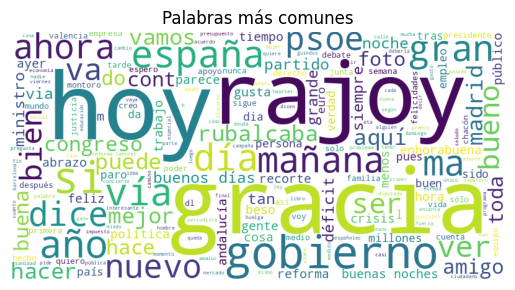

In [ ]:
wc = WordCloud(width = 800, height = 400, stopwords=sw, background_color='white', repeat = False)
wc.generate(content_norm_gral)
plt.axis('off')
plt.title('Palabras más comunes')
plt.imshow(wc)
plt.show()

In [ ]:
freq_gral = Counter(content_norm_gral.split())
palabras = list(freq_gral.keys())
freq_gral = list(freq_gral.values())

df_frq_gral = pd.DataFrame(zip(palabras,freq_gral),columns=['palabra','frecuencia'])
df_frq_gral.sort_values('frecuencia', inplace=True, ascending=False)

In [ ]:
df_frq_gral.head(10)

,palabra,frecuencia
0,gracias,296
33,hoy,258
46,si,233
592,rajoy,223
186,gobierno,214
26,día,147
138,vía,143
219,españa,139
308,ahora,135
169,gran,134


In [ ]:
p = ''
n = ''
neu = ''
for i in range(0,len(tags)):
  if tags[i] == 'P':
    p += content_norm[i]+' '
  elif tags[i] == 'N':
    n += content_norm[i]+' '
  #else:
    #neu += content_norm[i]+' '

dic_tags = {}
dic_tags['P'] = p
dic_tags['N'] = n
#dic_tags['NEU'] = neu

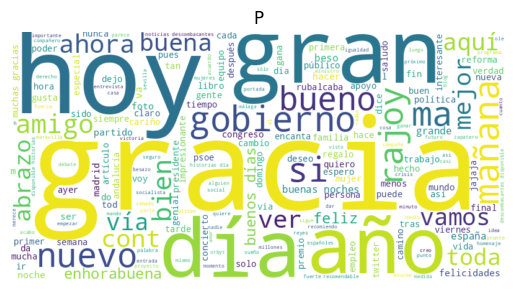

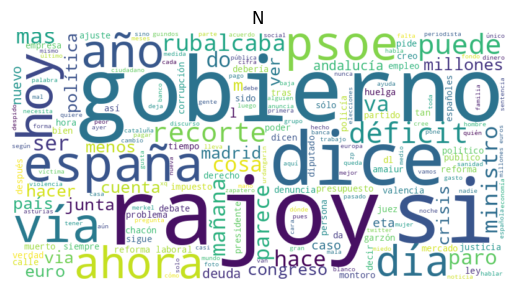

In [ ]:
for k,v in dic_tags.items():
  wc = WordCloud(width = 800, height = 400, stopwords = sw, background_color='white', repeat = False)
  wc.generate(v)
  plt.axis('off')
  plt.title(k)
  plt.imshow(wc, interpolation = 'bilinear')
  plt.show()

# Modelado

In [ ]:
modelos = {'MultinomialNB':MultinomialNB(),'SVM':LinearSVC(random_state=2023, max_iter=3000)}

## Vectorización con TFIDF

### División del conjunto de datos

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(content_norm, tags_norm, test_size = 0.25, random_state=2023, stratify=tags)

X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(content_lemma, tags_norm, test_size = 0.25, random_state=2023, stratify=tags)

X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(content_stem, tags_norm, test_size = 0.25, random_state=2023, stratify=tags)

In [ ]:
tfidfvec = TfidfVectorizer(stop_words=sw)

tfidfvec_fit = tfidfvec.fit(X_train)
tfidfvec_fit_lemma = tfidfvec.fit(X_train_lemma)
tfidfvec_fit_stem = tfidfvec.fit(X_train_stem)

X_train = tfidfvec_fit.transform(X_train)
X_test = tfidfvec_fit.transform(X_test)

X_train_lemma = tfidfvec_fit_lemma.transform(X_train_lemma)
X_test_lemma = tfidfvec_fit_lemma.transform(X_test_lemma)

X_train_stem = tfidfvec_fit_stem.transform(X_train_stem)
X_test_stem = tfidfvec_fit_stem.transform(X_test_stem)

### Evaluación

In [ ]:
eval = {}
for name, model in modelos.items():
  acc = []
  model.fit(X_train,y_train)
  acc.append(round(model.score(X_train,y_train),4))
  acc.append(round(model.score(X_test,y_test),4))
  eval[name] = acc

eval_lemma = {}
for name, model in modelos.items():
  acc = []
  model.fit(X_train_lemma,y_train_lemma)
  acc.append(round(model.score(X_train_lemma,y_train_lemma),4))
  acc.append(round(model.score(X_test_lemma,y_test_lemma),4))
  eval_lemma[name] = acc

eval_stem = {}
for name, model in modelos.items():
  acc = []
  model.fit(X_train_stem,y_train_stem)
  acc.append(round(model.score(X_train_stem,y_train_stem),4))
  acc.append(round(model.score(X_test_stem,y_test_stem),4))
  eval_stem[name] = acc

In [ ]:
eval

{'MultinomialNB': [0.7623, 0.6488], 'SVM': [0.7999, 0.6448]}

In [ ]:
eval_lemma

{'MultinomialNB': [0.7597, 0.6456], 'SVM': [0.7955, 0.6417]}

In [ ]:
eval_stem

{'MultinomialNB': [0.9229, 0.7585], 'SVM': [0.9911, 0.7616]}

## Vectorización con CountVectorizer

### División del conjunto de datos

In [ ]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(content, tags_norm, test_size = 0.25, random_state=2023, stratify=tags)

X_train_, X_test_, y_train_, y_test_ = train_test_split(content_norm, tags_norm, test_size = 0.25, random_state=2023, stratify=tags)

X_train_lemma_, X_test_lemma_, y_train_lemma_, y_test_lemma_ = train_test_split(content_lemma, tags_norm, test_size = 0.25, random_state=2023, stratify=tags)

X_train_stem_, X_test_stem_, y_train_stem_, y_test_stem_ = train_test_split(content_stem, tags_norm, test_size = 0.25, random_state=2023, stratify=tags)

In [ ]:
vectorizer = CountVectorizer(stop_words=sw)

vectorizer_fit = vectorizer.fit(X_train_)
vectorizer_lemma_fit = vectorizer.fit(X_train_lemma_)
vectorizer_stem_fit = vectorizer.fit(X_train_stem_)

X_train = vectorizer_fit.transform(X_train_)
X_test = vectorizer_fit.transform(X_test_)

X_train_lemma = vectorizer_lemma_fit.transform(X_train_lemma_)
X_test_lemma = vectorizer_lemma_fit.transform(X_test_lemma_)

X_train_stem = vectorizer_stem_fit.transform(X_train_stem_)
X_test_stem = vectorizer_stem_fit.transform(X_test_stem_)

### Evaluación

In [ ]:
eval = {}
for name, model in modelos.items():
  acc = []
  model.fit(X_train,y_train)
  acc.append(round(model.score(X_train,y_train),4))
  acc.append(round(model.score(X_test,y_test),4))
  eval[name] = acc

eval_lemma = {}
for name, model in modelos.items():
  acc = []
  model.fit(X_train_lemma,y_train_lemma)
  acc.append(round(model.score(X_train_lemma,y_train_lemma),4))
  acc.append(round(model.score(X_test_lemma,y_test_lemma),4))
  eval_lemma[name] = acc

eval_stem = {}
for name, model in modelos.items():
  acc = []
  model.fit(X_train_stem,y_train_stem)
  acc.append(round(model.score(X_train_stem,y_train_stem),4))
  acc.append(round(model.score(X_test_stem,y_test_stem),4))
  eval_stem[name] = acc

In [ ]:
eval

{'MultinomialNB': [0.7618, 0.6598], 'SVM': [0.8018, 0.6385]}

In [ ]:
eval_lemma

{'MultinomialNB': [0.7563, 0.6559], 'SVM': [0.796, 0.6377]}

In [ ]:
eval_stem

{'MultinomialNB': [0.9258, 0.7758], 'SVM': [0.9995, 0.7466]}

# Elección del modelo

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train_stem,y_train_stem)
y_stem_pred = mnb.predict(X_test_stem)

In [ ]:
acc_train = round(mnb.score(X_train_stem,y_train_stem),4)
acc_test = round(mnb.score(X_test_stem,y_test_stem),4)

print(f'Accuracy \nTrain: {acc_train}\nTest: {acc_test}')

Accuracy 
Train: 0.9258
Test: 0.7758


In [ ]:
confusion_matrix(y_test_stem,y_stem_pred)

array([[576, 145],
       [139, 407]])

In [ ]:
print(classification_report(y_test_stem,y_stem_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       721
           1       0.74      0.75      0.74       546

    accuracy                           0.78      1267
   macro avg       0.77      0.77      0.77      1267
weighted avg       0.78      0.78      0.78      1267



In [ ]:
df_pred = pd.DataFrame(zip(X_test_c,X_test_stem_,y_stem_pred), columns = ['text','text_stem','Sentiment'])
df_pred_p = df_pred.loc[df_pred['Sentiment'] == 0,'text']
df_pred_n = df_pred.loc[df_pred['Sentiment'] == 1,'text']

## Muestra de comentarios clasificados como **Positivos** en el conjunto de prueba

In [ ]:
df_pred_p.head(10).tolist()

['Un cuento infantil de mi amiguete Juancho, si os gusta votar por el que es buena gentehttp://t.co/yq0UuWXf',
 'Y mil #FF más para ella RT @fernandomorales: Mi #FF es único, exclusivo e intransferible para @sanchez_sonia por muchas cosas. #hedicho',
 'Muy buenas noches followercetes! http://t.co/RYgHXuLU',
 'Un abrazo a las hermandades de todas las ciudades. Que vivan la Semana Santa con la pasion que le debemos a ... http://t.co/KnlGKu4l',
 '"@Labrujulacom: Desde nuestra pequeña agencia estamos deslumbrados por tu libro, we want more!! :) thanks xxx" URwelcome!',
 'Bueno lo dicho... Buenas noches... Os quiero familia!!!',
 'Me voy a dormir, escuchando cantar al gallo que tiene mi vecino en la sierra... Esto no es por las mañanas????',
 'un buen trabajo...“@LaVanguardia: La NASA busca astronautas para ir a un asteroide http://t.co/o6kjfQLj”',
 'Hoy veré este maravilloso concierto de Juan Gabriel y Rocìo Dúrcal grabado el teatro Degollado de Guadalajara 1997 http://t.co/wnlceJ8e',
 'Va

## Muestra de comentarios clasificados como **Negativos** en el conjunto de prueba

In [ ]:
df_pred_n.head(10).tolist()

['Los mºEducación UE discuten medidas concretas para reducir paro juvenil.Wert presenta prioridades Gobierno en educación a comisaria del ramo',
 'Hubiese dado cualquier cosa por abrazar a mi madre, sentir su presencia...En el fondo era un creyente potencial#queremoscreer',
 '@cayo_lara has pedido perfon por quitarle derecho a voto a los paraplejicos? Desafortunado simil cuanto menos',
 'La UE prevé que España suba impuestos, todo listo para la huelga y la renta mínima de inserción, amenazadahttp://t.co/jXmep9Rn#portadaEPC',
 'Los gráficos no pueden hacer su trabajo en Justicia. Se oyen voces en alto que dicen “no se puede trabajar así”',
 "Alfonso Alonso: 'Amaiur no cumple el reglamento para formar grupo propio' | elmundo.es http://t.co/eqFpFPmm",
 'DGT: En general se registran las mismas retenciones de tráfico a esta hora, que el jueves pasado',
 'Iberia cancelará 107 vuelos este viernes por la huelga de pilotos - http://t.co/GGPDnBZ1',
 'Pues la mejor es la 1 :)) “@espidifen600mg: @

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 2023)
param_grid = {'alpha':np.linspace(1,3,10)}
mnb = MultinomialNB()
mnb_cv = RandomizedSearchCV(mnb, param_grid, cv =kf, n_iter=2)
mnb_cv.fit(X_train_stem,y_train_stem)
print(mnb_cv.best_params_, mnb_cv.best_score_)
print(mnb_cv.score(X_test_stem,y_test_stem))

{'alpha': 2.111111111111111} 0.7902080299563137
0.7742699289660616


In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 2023)
param_grid = {'alpha':np.linspace(1,3,10)}
mnb = MultinomialNB()
mnb_cv = GridSearchCV(mnb, param_grid, cv =kf)
mnb_cv.fit(X_train_stem,y_train_stem)
print(mnb_cv.best_params_, mnb_cv.best_score_)
print(mnb_cv.score(X_test_stem,y_test_stem))

{'alpha': 1.2222222222222223} 0.7904725747174259
0.7774269928966061


In [ ]:
np.linspace(0.0001,2,10)

# Análisis de sentimientos a los horóscopos

In [ ]:
horoscopos = pd.read_excel('horoscopos_sentimenta.xlsx')

In [ ]:
horoscopos.head()

,Signo,Horoscopo,horos_norm
0,Aries,"Te sale la carta de ‘El Mago’, lo que nos indi...",te sal la cart de el mag lo que nos indic que ...
1,Tauro,El ‘AS de Bastos’ nos indica que se vienen var...,el as de bast nos indic que se vien vari dias ...
2,Géminis,"La carta de ‘La Torre’, que nos dice que estás...",la cart de la torr que nos dic que estás hac a...
3,Cáncer,La carta de ‘El Juicio’ nos dice que son momen...,la cart de el juici nos dic que son moment de ...
4,Leo,La carta del ‘Sol’ nos dice que brillarás much...,la cart del sol nos dic que brill mucho en los...


In [ ]:
#Vectorización
X_h = vectorizer_stem_fit.transform(horoscopos['horos_norm'])

#Predicción
y_h_pred = mnb.predict(X_h)

In [ ]:
horoscopos = horoscopos.assign(Sentiment = y_h_pred)
horoscopos.head()

,Signo,Horoscopo,horos_norm,Sentiment
0,Aries,"Te sale la carta de ‘El Mago’, lo que nos indi...",te sal la cart de el mag lo que nos indic que ...,0
1,Tauro,El ‘AS de Bastos’ nos indica que se vienen var...,el as de bast nos indic que se vien vari dias ...,0
2,Géminis,"La carta de ‘La Torre’, que nos dice que estás...",la cart de la torr que nos dic que estás hac a...,0
3,Cáncer,La carta de ‘El Juicio’ nos dice que son momen...,la cart de el juici nos dic que son moment de ...,0
4,Leo,La carta del ‘Sol’ nos dice que brillarás much...,la cart del sol nos dic que brill mucho en los...,0


In [ ]:
df_h_senti = horoscopos.pivot_table(index='Signo', columns='Sentiment', values = 'horos_norm', aggfunc = 'count', fill_value = 0)
df_h_senti.reset_index(inplace = True)
df_h_senti.rename(columns={0:'Positivo',1:'Negativo'}, inplace = True)
df_h_senti

Sentiment,Signo,Positivo,Negativo
0,Acuario,11,3
1,Aries,17,0
2,Capricornio,7,7
3,Cáncer,15,2
4,Escorpión,14,1
5,Géminis,12,3
6,Leo,10,4
7,Libra,10,5
8,Piscis,12,2
9,Sagitario,12,3


In [ ]:
horoscopos.loc[(horoscopos['Sentiment']==1) & (horoscopos['Signo']=='Escorpión'),'Horoscopo'].tolist()

['La carta de ‘El Loco’ nos dice que es un mes de madurar, de buscar tus metas. Es tiempo de crecer, puedes poner un negocio. Ten cuidado con los problemas de separación. Se moverán las energías y podrás reinventarte en forma. La buena suerte es tuya. Trata de comer mejor y tomar más agua. Si estás casado, ten cuidado con los pleitos. Es momento de cambiar de casa, para empezar a crecer. Eres una luz para muchas personas. Trata de lograr tus objetivos. Cuídate mucho.']

In [ ]:
#Función para normalizar el texto y eliminar Stop words
def norm_tex(text):
  x = text.replace('‘','').replace('’','').replace(',','').replace('.','').lower()
  x = x.split()
  x = ' '.join([w for w in x if not w in sw+['dice','carta','semana']])
  return x

In [ ]:
#Normalizamos y eliminamos Stop words, para revisar las palabras que más se repiten por polaridad
horoscopos['horos_norm_2'] = horoscopos['Horoscopo'].apply(norm_tex)

#Generar 2 dataframes filtrando por polaridad
horoscopos_p = horoscopos.loc[horoscopos['Sentiment']==0,'horos_norm_2']
horoscopos_n = horoscopos.loc[horoscopos['Sentiment']==1,'horos_norm_2']

In [ ]:
#Se concatenan los textos
h_p_ = ''
for l in horoscopos_p:
  l = l.split()
  l.append(' ')
  l = ' '.join(l)
  h_p_ += l
h_p_.replace('  ',' ')

h_n_ = ''
for l in horoscopos_n:
  l = l.split()
  l.append(' ')
  l = ' '.join(l)
  h_n_ += l
h_n_.replace('  ',' ')

#Se obtienen frecuencias
h_p = Counter(h_p_.split())
h_n = Counter (h_n_.split())

palabras_en_p = list(h_p.keys())
frec_en_p = list(h_p.values())

palabras_en_n = list(h_n.keys())
frec_en_n = list(h_n.values())

df_positivas = pd.DataFrame(zip(palabras_en_p,frec_en_p), columns = ['Palabra','Frecuencia'])
df_negativas = pd.DataFrame(zip(palabras_en_n,frec_en_n), columns = ['Palabra','Frecuencia'])

df_positivas.sort_values('Frecuencia', ascending = False, inplace = True)
df_positivas.reset_index(inplace = True, drop = True)

df_negativas.sort_values('Frecuencia', ascending = False, inplace = True)
df_negativas.reset_index(inplace = True, drop = True)

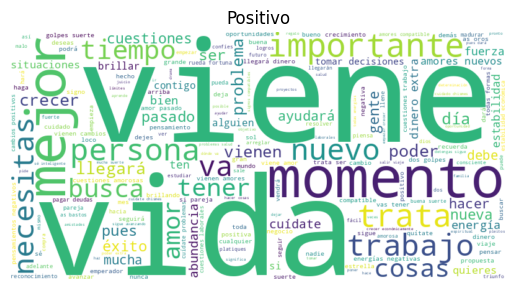

In [ ]:
wc = WordCloud(width = 800, height = 400, stopwords = sw, background_color='white', repeat = False)
wc.generate(h_p_)
plt.axis('off')
plt.title('Positivo')
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

In [ ]:
df_positivas.head(10)

,Palabra,Frecuencia
0,viene,70
1,vida,62
2,amor,58
3,trata,57
4,mejor,56
5,trabajo,53
6,cuestiones,51
7,momento,50
8,dinero,46
9,vienen,45


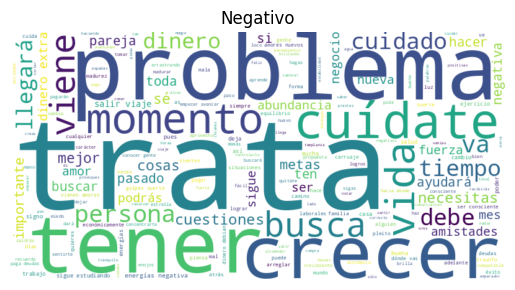

In [ ]:
wc = WordCloud(width = 800, height = 400, stopwords = sw, background_color='white', repeat = False)
wc.generate(h_n_)
plt.axis('off')
plt.title('Negativo')
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

In [ ]:
df_negativas.head(10)

,Palabra,Frecuencia
0,trata,30
1,problemas,22
2,dinero,20
3,tener,20
4,crecer,17
5,cuídate,16
6,vas,15
7,vida,14
8,busca,13
9,momento,13


In [ ]:
print(f'positivos: {horoscopos_p.shape[0]} \nNegativos: {horoscopos_n.shape[0]}')

positivos: 139 
Negativos: 39
